In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scanpy as sc

## Comparisons

In [199]:
ordered_genes = np.load("ordered_genes.npy")
ordchrs = np.load("ordered_chrs.npy")
pal = {"del":"blue","neut":"grey","amp":"red"}

def eta_no_bin(eta):
    inds = []
    draw_lines = []
    ch = 'chr1'
    chr_list = [ch]
    count=0
    for i in range(len(ordered_genes)):
        if ordered_genes[i] in eta.index:
            inds.append(ordered_genes[i])
            count+=1
            if ordchrs[i]!=ch:
                draw_lines.append(count)
                ch=ordchrs[i]
                chr_list.append(ch)
    draw_lines.append(count)
    return draw_lines, chr_list, inds



In [50]:
echid_status.columns=["status"]
echid_status.to_csv("echid_status.csv")

In [212]:
files = os.listdir("infercnv")
[i for i in files if "R310" in i and "on1" not in i]

['R310_pre_infercnv.csv', 'R310_on2_infercnv.csv']

R310


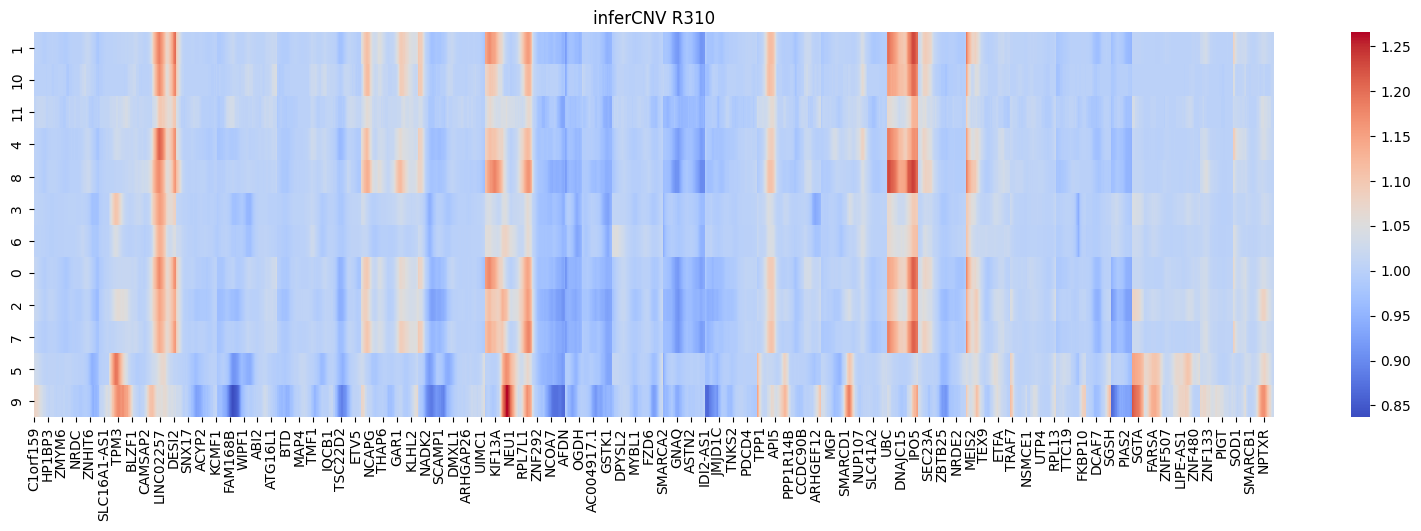

In [229]:
PATH = "params_mt_refined/"
for patient in ["R310"]:
    if "_" not in patient:
        print(patient)
        files = os.listdir("infercnv")
        read = [i for i in files if patient in i and "on1" not in i]
        infer_on = pd.read_csv("infercnv/"+read[0], index_col=0)
        infer_pre = pd.read_csv("infercnv/"+read[1], index_col=0)
    
        Xad = sc.read_h5ad("params_mt_refined/samples/"+patient+"/X.h5")
        infercnv = pd.concat((infer_pre.loc[list(np.intersect1d(infer_pre.index, infer_on.index))], 
                              infer_on.loc[list(np.intersect1d(infer_pre.index, infer_on.index))]),axis=1).T
        
        infer_inds = [i.split("-")[0] for i in infercnv.index]
        
        infercnv.index = infer_inds
        
        inds = pd.DataFrame(list(np.unique(infer_inds,return_counts=True)[0]))
        inds["counts"]=np.unique(infer_inds,return_counts=True)[1]
        
        inds = inds[inds['counts']==1]
        
        infercnv = infercnv.loc[inds[0]]
        
        X_inds = [i.split("-")[0] for i in Xad.obs_names]
        Xad.obs_names=X_inds
        
        x_inds = pd.DataFrame(list(np.unique(X_inds,return_counts=True)[0]))
        x_inds["counts"]=np.unique(X_inds,return_counts=True)[1]
        x_inds = x_inds[x_inds['counts']==1]
        
        tmp_X = Xad.obs.loc[x_inds[0]]
        
        clusters = pd.DataFrame(tmp_X["leiden"])
        clusters.index = tmp_X.index
        
        infercnv = infercnv.loc[np.intersect1d(x_inds[0],infercnv.index)]
        clusters = clusters.loc[np.intersect1d(x_inds[0],infercnv.index)]
        
        infercnv["clusters"]=clusters["leiden"]
        
        infer_heatmap=pd.DataFrame()
        for i in np.unique(infercnv["clusters"]):
            infer_heatmap[i]=np.mean(np.asarray(infercnv[infercnv["clusters"]==i].drop("clusters",axis=1)),axis=0)
        infer_heatmap.index=infercnv.columns[:-1]
        
        clust_order = []
        obs = Xad.obs
        for i in np.unique(obs["eta_clones"]):
            clust_order+=list(np.unique(obs[obs["eta_clones"]==i]["leiden"]))
        
        eta = pd.read_csv("params_mt_refined/samples/"+patient+"/eta.csv",index_col=0).T
        intersect = np.intersect1d(infer_heatmap.index, eta.columns)
        ordered = [i for i in ordered_genes if i in intersect]
    
        eta = eta.loc[clust_order][ordered]
        infer_heatmap = infer_heatmap[clust_order].loc[ordered]
    
        plt.figure(figsize=(20,5))
        sns.heatmap(infer_heatmap.T, cmap='coolwarm')
        plt.title("inferCNV "+patient)
        #plt.savefig("FIGURES/inferCNV_r319.pdf",dpi=300)
        #eta_smoothed = scipy.ndimage.gaussian_filter1d(eta, sigma=6, axis=1, radius=8)
        
        #plt.figure(figsize=(20,5))
        #sns.heatmap(pd.DataFrame(eta_smoothed, index=clust_order), cmap='coolwarm')
        #plt.title("Eta "+patient)

In [ ]:
draw_lines, chr_list, genes = eta_no_bin(infer_heatmap)
plot = infer_heatmap.loc[genes]

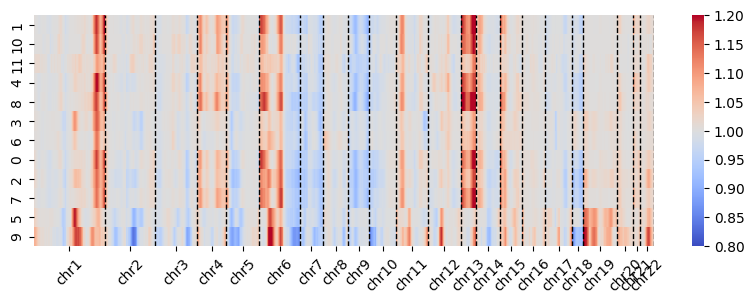

In [239]:
plt.figure(figsize=(10,3))
sns.heatmap(plot.T, cmap='coolwarm', vmin=0.8, vmax=1.2)

ticklines = []
for i in range(len(draw_lines)):
    plt.axvline(x=draw_lines[i], color='black', linestyle='--', linewidth=1)
    if i==0:
        ticklines.append(draw_lines[i]-.5*draw_lines[0])
        #plt.text(draw_lines[i]-.5*draw_lines[0], delta_wgs.T.shape[0]+.4, chr_list[i], color='black', fontsize=10, rotation=45)
    else:
        ticklines.append(draw_lines[i-1]+.5*(draw_lines[i]-draw_lines[i-1]))
        #plt.text(draw_lines[i-1]+.5*(draw_lines[i]-draw_lines[i-1]), delta_wgs.T.shape[0]+.4, chr_list[i], color='black', fontsize=10, rotation=45)
plt.xticks(ticklines, labels=chr_list, rotation=45)
plt.xlabel(None)
plt.savefig("InferCNV_chr_heatmap.pdf", dpi=300)

In [249]:
Xad = sc.read_h5ad("params_mt_refined/samples/"+patient+"/X.h5")

In [250]:
tmp = sc.read_h5ad("N_ribas310_clones.h5")

In [251]:
tp = pd.DataFrame(np.unique([i.split('-')[0]+"-"+i.split('-')[1] for i in tmp.obs_names], return_counts=True)).T
dups = tp[tp[1]>1][0]

In [252]:
tmp.obs_names = [i.split('-')[0]+"-"+i.split('-')[1] for i in tmp.obs_names]

In [253]:
inds = []
for i in range(len(tmp.obs_names)):
    if tmp.obs_names[i] not in list(dups):
        inds.append(i)

In [254]:
tmp = tmp[inds,:]

In [255]:
ints = np.intersect1d(tmp.obs_names, Xad.obs_names)
tmp = tmp[ints]
Xad = Xad[ints]

In [256]:
Xad.obs["infercnv_clones"]=pd.Categorical(tmp.obs["inferCNV_clones"])

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_59539/276861928.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  Xad.obs["infercnv_clones"]=pd.Categorical(tmp.obs["inferCNV_clones"])


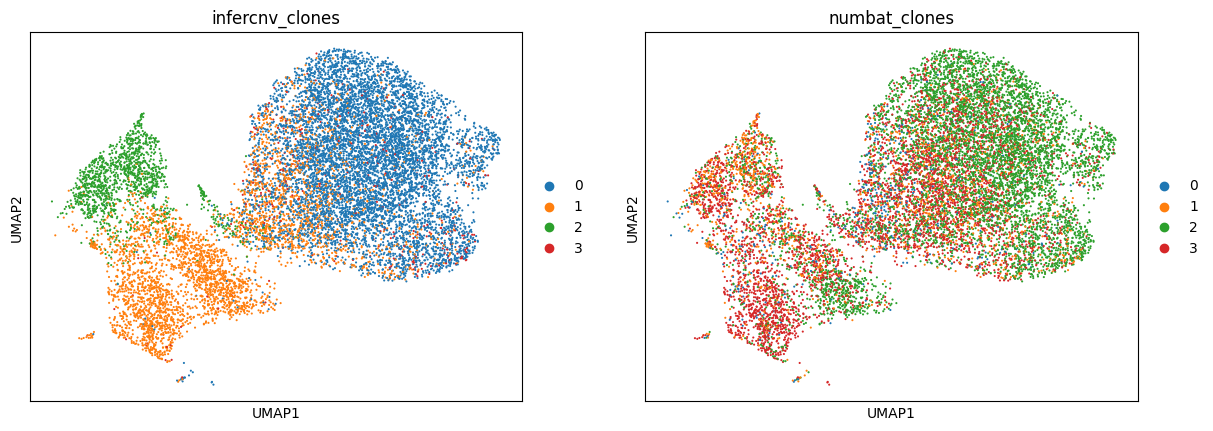

In [257]:
sc.pl.umap(Xad, color=["infercnv_clones","numbat_clones"])#,save="FIGURES/infer_numbat_umaps.pdf")
#plt.savefig("FIGURES/infer_numbat_umaps.pdf",dpi=300)

In [183]:
obs = Xad.obs
for i in np.unique(obs["leiden"]):
    subs = obs.loc[obs[obs["leiden"]==i].index]["infercnv_clones"]
    tp = pd.DataFrame(np.unique(subs, return_counts=True)).T.sort_values(by=1, ascending=False)
    print(i, tp.iloc[0][0])

0 0
1 0
10 0
11 1
2 0
3 1
4 0
5 2
6 1
7 0
8 0
9 2


In [263]:
numbat_bulk = pd.read_csv("R310_bulk_clones_final.tsv", sep='\t', compression='gzip')
numbat_bulk = numbat_bulk[numbat_bulk['LLR'] >= 10]
numbat_bulk = numbat_bulk[numbat_bulk['n_cells'] > 50]
gene_cnv = (numbat_bulk
            .groupby(['sample', 'gene'], as_index=False)
            .agg(median_phi_mle=('phi_mle', 'median')))
gene_cnv['est_cn'] = gene_cnv['median_phi_mle']
clone_by_gene = gene_cnv.pivot(index='sample', columns='gene', values='est_cn')
clone_by_gene.fillna(1.0, inplace=True)
clone_by_gene.loc[1] = [1.0] * len(clone_by_gene.columns)
clone_by_gene.index.names = ['clone_opt']
numbat_clones = pd.read_csv("R310_clone_post_2.tsv", sep='\t')
numbat_clones.index = numbat_clones['cell']
overlapping_barcodes = set(list(Xad.obs_names)).intersection(set(list(numbat_clones.index)))
Xad = Xad[Xad.obs_names.isin(overlapping_barcodes)]
numbat_clones = numbat_clones.loc[list(overlapping_barcodes)]
numbat_clones = numbat_clones.reindex(Xad.obs_names)
nb_clones = numbat_clones[['cell', 'clone_opt']]
nb_clones = nb_clones.dropna() #this is a debug line. there shouldn't be nans if everything is correct
print(set(nb_clones['clone_opt']) - set(clone_by_gene.index)) #this is a debug line. should print empty set
nb_cnv = nb_clones.join(clone_by_gene, on='clone_opt').drop(columns=['cell', 'clone_opt']) # this is gene by cell

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_59539/3930167951.py:1: DtypeWarning: Columns (28,84,85) have mixed types. Specify dtype option on import or set low_memory=False.
  numbat_bulk = pd.read_csv("R310_bulk_clones_final.tsv", sep='\t', compression='gzip')


set()


In [265]:
nb_cnv["clusters"] = Xad.obs["leiden"]

In [267]:
draw_lines, chr_list, genes = eta_no_bin(infer_heatmap)
plot = infer_heatmap.loc[genes]

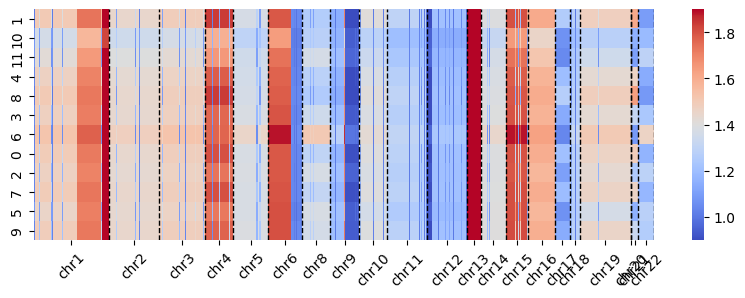

In [278]:
plt.figure(figsize=(10,3))
sns.heatmap(plot.T, cmap='coolwarm', vmin=.9, vmax=1.9)

ticklines = []
for i in range(len(draw_lines)):
    plt.axvline(x=draw_lines[i], color='black', linestyle='--', linewidth=1)
    if i==0:
        ticklines.append(draw_lines[i]-.5*draw_lines[0])
        #plt.text(draw_lines[i]-.5*draw_lines[0], delta_wgs.T.shape[0]+.4, chr_list[i], color='black', fontsize=10, rotation=45)
    else:
        ticklines.append(draw_lines[i-1]+.5*(draw_lines[i]-draw_lines[i-1]))
        #plt.text(draw_lines[i-1]+.5*(draw_lines[i]-draw_lines[i-1]), delta_wgs.T.shape[0]+.4, chr_list[i], color='black', fontsize=10, rotation=45)
plt.xticks(ticklines, labels=chr_list, rotation=45)
plt.xlabel(None)
plt.savefig("Numbat_chr_heatmap.pdf", dpi=300)

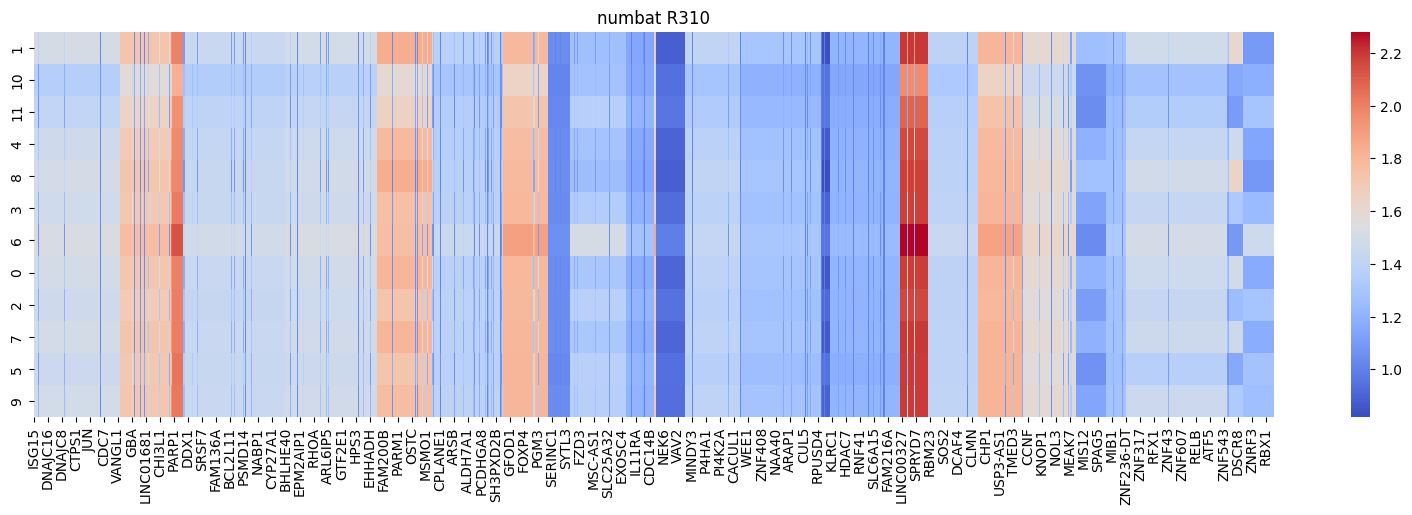

In [197]:
infer_heatmap=pd.DataFrame()
for i in np.unique(nb_cnv["clusters"]):
    infer_heatmap[i]=np.mean(np.asarray(nb_cnv[nb_cnv["clusters"]==i].drop("clusters",axis=1)),axis=0)
infer_heatmap.index=nb_cnv.columns[:-1]

clust_order = []
obs = Xad.obs
for i in np.unique(obs["eta_clones"]):
    clust_order+=list(np.unique(obs[obs["eta_clones"]==i]["leiden"]))

eta = pd.read_csv("params_mt_refined/samples/"+patient+"/eta.csv",index_col=0).T
intersect = np.intersect1d(infer_heatmap.index, eta.columns)
ordered = [i for i in ordered_genes if i in intersect]

eta = eta.loc[clust_order][ordered]
infer_heatmap = infer_heatmap[clust_order].loc[ordered]

plt.figure(figsize=(20,5))
sns.heatmap(infer_heatmap.T, cmap='coolwarm')
plt.title("numbat "+patient)
#plt.savefig("FIGURES1/numbat_R310.pdf",dpi=300)

In [198]:
obs = Xad.obs
for i in np.unique(obs["leiden"]):
    subs = obs.loc[obs[obs["leiden"]==i].index]["numbat_clones"]
    tp = pd.DataFrame(np.unique(subs, return_counts=True)).T.sort_values(by=1, ascending=False)
    print(i, tp.iloc[0][0])

0 2
1 2
10 1
11 3
2 3
3 2
4 2
5 3
6 3
7 2
8 2
9 2
